Test model training

In [1]:
import os
import time

import numpy as np
import cv2

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from dataloader import CityScapesDataset
from transformations import *

## Configs

In [2]:
BATCH_SIZE = 16
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Get Data

In [68]:
root = "C:/Users/itber/Documents/datasets/cityscapes"
OG_W, OG_H = 2048, 800 # OG width and height after crop
W, H = OG_W//4, OG_H//4 # resize w,h for training

transform = transforms.Compose([
    ToTensor(),
    RandomCrop(H, W),
    # Rescale(H, W),
    AddColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    RandomHorizontalFlip(0.5),
    RandomVerticalFlip(0.2),
    # RandomRotate((-30, 30)),
    Normalize()
])

valid_transform = transforms.Compose([
    ToTensor(),
    Rescale(H, W),
    Normalize()
])

test_transform = transforms.Compose([
    ToTensor(),
    Normalize()
])

In [69]:
from dataloader import CityScapesDataset

train_dataset = CityScapesDataset(root, transform=transform, split='train', label_map='trainId') # 'trainId')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False) # set Shuffle to True

valid_dataset = CityScapesDataset(root, transform=valid_transform, split='val', label_map='trainId')
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)

test_dataset = CityScapesDataset(root, transform=test_transform, split='test', label_map='trainId')
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)

In [5]:
train_dataset.trainid_2_name

{19: 'unlabeled',
 0: 'road',
 1: 'sidewalk',
 2: 'building',
 3: 'wall',
 4: 'fence',
 5: 'pole',
 6: 'traffic light',
 7: 'traffic sign',
 8: 'vegetation',
 9: 'terrain',
 10: 'sky',
 11: 'person',
 12: 'rider',
 13: 'car',
 14: 'truck',
 15: 'bus',
 16: 'train',
 17: 'motorcycle',
 18: 'bicycle'}

In [6]:
NUM_SEG_CLASSES = len(train_dataset.trainid_2_name)
NUM_SEG_CLASSES

20

In [7]:
from labels import labels

def convert_to_numpy(image):
    if not isinstance(image, np.ndarray):
        if len(image.shape) == 2:
            image = image.detach().cpu().numpy()
        else:
            image = image.detach().cpu().numpy().transpose(1, 2, 0)

    return image

def get_color_mask(mask, labels, id_type='id'):
    try:
        h, w = mask.shape
    except ValueError:
        mask = mask.squeeze(-1)
        h, w = mask.shape

    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    if id_type == 'id':
        for lbl in labels:
            color_mask[mask == lbl.id] = lbl.color
    elif id_type == 'trainId':
        for lbl in labels:
            if (lbl.trainId != 255) | (lbl.trainId != -1):
                color_mask[mask == lbl.trainId] = lbl.color

    return color_mask


def plot_items(left, mask, depth, labels=None, num_seg_labels=34, id_type='id'):
    left = convert_to_numpy(left)
    mask = convert_to_numpy(mask)
    depth = convert_to_numpy(depth)

    # unnormalize left image
    left = (left*np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])

    # cmaps: 'prism', 'terrain', 'turbo', 'gist_rainbow_r', 'nipy_spectral_r'
    
    
    _, ax = plt.subplots(1, 3, figsize=(15,10))
    ax[0].imshow(left)
    ax[0].set_title("Left Image")

    if labels:
        color_mask = get_color_mask(mask, labels, id_type)
        ax[1].imshow(color_mask)
    else:
        cmap = mpl.colormaps.get_cmap('nipy_spectral_r').resampled(num_seg_labels)
        ax[1].imshow(mask, cmap=cmap)

    ax[1].set_title("Seg Mask")
    ax[2].imshow(depth, cmap='hot')
    ax[2].set_title("Depth")

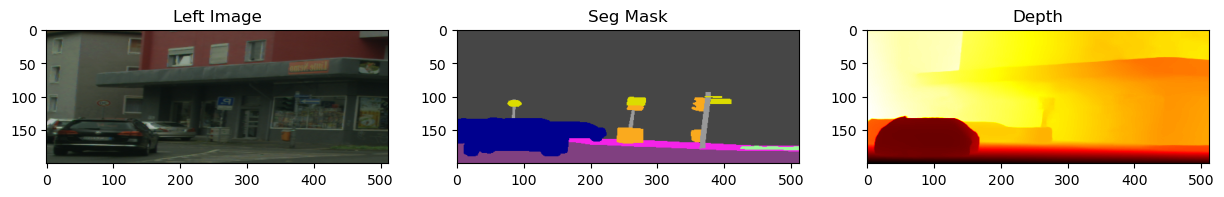

In [9]:
idx = 202
sample = train_dataset[idx]
left, mask, depth = sample['left'], sample['mask'], sample['depth']

plot_items(left, mask.squeeze(0), depth.squeeze(0), labels=labels, id_type='trainId');

## Get Model

In [10]:
from torchvision.models import mobilenet_v3_small
from model import MobileNetV3Backbone, LightWeightRefineNet, MultiTaskNetwork


mobilenet_backbone = mobilenet_v3_small(weights='IMAGENET1K_V1')

encoder = MobileNetV3Backbone(mobilenet_backbone.features)
decoder = LightWeightRefineNet(NUM_SEG_CLASSES)
model = MultiTaskNetwork(encoder, decoder).to(DEVICE)

In [11]:
from torch.optim.lr_scheduler import OneCycleLR



optimizer = optim.Adam(model.parameters(), lr=1e-4)

# loss functions
def seg_criterion(pred, target, batch_size=BATCH_SIZE, num_classes=NUM_SEG_CLASSES):
    # return nn.CrossEntropyLoss()(
    #             pred.view(batch_size, num_classes, -1), 
    #             target.view(batch_size, -1).to(torch.long))
    return nn.CrossEntropyLoss()(pred, target)

depth_criterion = nn.MSELoss()

# scheduler
scheduler = OneCycleLR(optimizer, 
                       max_lr=1e-3,                       # Upper learning rate boundaries in the cycle for each parameter group
                       steps_per_epoch=len(train_loader), # The number of steps per epoch to train for.
                       epochs=100,                        # The number of epochs to train for.
                       anneal_strategy='cos')             # Specifies the annealing strategy


In [12]:
from torchmetrics import JaccardIndex

jaccard = JaccardIndex(task='multiclass', threshold=0.5, num_classes=NUM_SEG_CLASSES) # usage: jaccard(pred, target)

# def compute_iou(pred, target, batch_size=BATCH_SIZE, num_classes=NUM_SEG_CLASSES):
#     jaccard(pred.view(batch_size, num_classes, -1), 
#             target.view(batch_size, -1).to(torch.long))


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, window_size=None):
        self.length = 0
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.window_size = window_size

    def reset(self):
        self.length = 0
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        if self.window_size and (self.count >= self.window_size):
            self.reset()
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.round(self.sum / self.count, 4)

In [13]:
def train(model, device, epochs, optimizer, seg_criterion, depth_criterion, batch_size=BATCH_SIZE, num_seg_classes=NUM_SEG_CLASSES):
    model.to(device).train()

    best_valid_loss = np.inf

    avg_train_metrics = {
        'seg_losses' : [],
        'depth_losses' : [],
        'losses' : [],
        'iou' : []
    }

    avg_valid_metrics = {
        'seg_losses' : [],
        'depth_losses' : [],
        'losses' : [],
        'iou' : []
    }
    

    for e in range(1, epochs + 1):
        train_metrics = {
            'seg_losses' : AverageMeter(),
            'depth_losses' : AverageMeter(),
            'losses' : AverageMeter(),
            'iou' : AverageMeter()
        }

        model.train()

        for i, sample in enumerate(train_loader):
            left, mask, depth = sample['left'], sample['mask'].squeeze(1), sample['depth'].squeeze(1)
            left, mask, depth = left.to(device), mask.to(device), depth.to(device)

            # get predictions
            pred_seg, pred_depth = model(left)

            # reshape seg
            pred_seg = pred_seg.view(batch_size, num_seg_classes, -1)
            mask = mask.view(batch_size, -1).to(torch.long)

            # compute losses
            # seg_loss = seg_criterion(mask.squeeze(1).long(), pred_seg.argmax(dim=1))
            seg_loss = seg_criterion(pred_seg, mask)
            depth_loss = depth_criterion(depth, pred_depth)
            loss = seg_loss + depth_loss

            # zero gradients (must do before backprop?)
            optimizer.zero_grad()

            # back prop loss
            loss.backward()

            # step weights
            optimizer.step()

            # store metrics
            train_metrics['seg_losses'].update(seg_loss.item())
            train_metrics['depth_losses'].update(depth_loss.item())
            train_metrics['losses'].update(loss.item())
            train_metrics['iou'].update(jaccard(pred_seg.detach().cpu(), mask.detach().cpu()).numpy())
        
        # save average metrics
        avg_train_metrics['seg_losses'].append(np.round(train_metrics['seg_losses'].avg, 3))
        avg_train_metrics['depth_losses'].append(np.round(train_metrics['depth_losses'].avg, 3))
        avg_train_metrics['losses'].append(np.round(train_metrics['losses'].avg, 3))
        avg_train_metrics['iou'].append(np.round(train_metrics['iou'].avg, 3))

        # display avg train metrics
        print(f"epoch {e} - avg seg loss: {avg_train_metrics['seg_losses'][-1]}")
        print(f" - avg train_loss: {avg_train_metrics['depth_losses'][-1]} - avg loss: {avg_train_metrics['losses'][-1]}")
        print(f"- avg IOU: {avg_train_metrics['iou'][-1]}")

    # validate model
    valid_metrics = {
        'seg_losses' : AverageMeter(),
        'depth_losses' : AverageMeter(),
        'losses' : AverageMeter(),
        'iou' : AverageMeter()
    }
    
    model.eval()
    with torch.no_grad():
        for i, sample in enumerate(train_loader):
            left, mask, depth = sample['left'], sample['mask'].squeeze(1), sample['depth'].squeeze(1)
            left, mask, depth = left.to(device), mask.to(device), depth.to(device)

            # get predictions
            pred_seg, pred_depth = model(left)

            # reshape seg
            pred_seg = pred_seg.view(batch_size, num_seg_classes, -1)
            mask = mask.view(batch_size, -1).to(torch.long)

            # compute losses
            # seg_loss = seg_criterion(mask.squeeze(1).long(), pred_seg.argmax(dim=1))
            seg_loss = seg_criterion(pred_seg, mask)
            depth_loss = depth_criterion(depth, pred_depth)
            loss = seg_loss + depth_loss

            # store metrics
            valid_metrics['seg_losses'].update(seg_loss.item())
            valid_metrics['depth_losses'].update(depth_loss.item())
            valid_metrics['losses'].update(loss.item())
            valid_metrics['iou'].update(jaccard(pred_seg.detach().cpu(), mask.detach().cpu()).numpy())

        # save average metrics
        avg_valid_metrics['seg_losses'].append(np.round(valid_metrics['seg_losses'].avg, 3))
        avg_valid_metrics['depth_losses'].append(np.round(valid_metrics['depth_losses'].avg, 3))
        avg_valid_metrics['losses'].append(np.round(valid_metrics['losses'].avg, 3))
        avg_valid_metrics['iou'].append(np.round(valid_metrics['iou'].avg, 3))

        # display train metrics
        print(f"epoch {e} - seg loss: {avg_valid_metrics['seg_losses'][-1]}")
        print(f" - train_loss: {avg_valid_metrics['depth_losses'][-1]} - loss: {avg_valid_metrics['losses'][-1]}")
        print(f"- IOU: {avg_valid_metrics['iou'][-1]}")

        # save best model based on overall loss
        if avg_valid_metrics['losses'] >= best_valid_loss:
            best_valid_loss = avg_valid_metrics['losses']


    # return model
    

In [14]:
model_root = r'C:\Users\itber\Documents\learning\self_tutorials\CV_projects\multitask_depth_seg\models'

NameError: name 'e' is not defined

In [15]:
# find optimal backend for performning convolutions
torch.backends.cudnn.benchmark = True

In [17]:
epochs = 100
device = 'cuda'
model_root = r'C:\Users\itber\Documents\learning\self_tutorials\CV_projects\multitask_depth_seg\models'

model.to(device).train()

best_valid_loss = np.inf

avg_train_metrics = {
    'seg_losses' : [],
    'depth_losses' : [],
    'losses' : [],
    'iou' : []
}

avg_valid_metrics = {
    'seg_losses' : [],
    'depth_losses' : [],
    'losses' : [],
    'iou' : []
}


for e in range(1, epochs + 1):
    train_metrics = {
        'seg_losses' : AverageMeter(),
        'depth_losses' : AverageMeter(),
        'losses' : AverageMeter(),
        'iou' : AverageMeter()
    }

    model.train()

    for i, sample in enumerate(train_loader):
        left, mask, depth = sample['left'], sample['mask'].squeeze(1), sample['depth'].squeeze(1)
        left, mask, depth = left.to(device), mask.to(device), depth.to(device)

        # get predictions
        pred_seg, pred_depth = model(left)

        # reshape seg
        pred_seg = pred_seg.view(BATCH_SIZE, NUM_SEG_CLASSES, -1)
        mask = mask.view(BATCH_SIZE, -1).to(torch.long)
        
        # compute losses
        seg_loss = seg_criterion(pred_seg, mask)
        depth_loss = depth_criterion(depth, pred_depth)
        loss = seg_loss + depth_loss

        # zero gradients (must do before backprop?)
        optimizer.zero_grad()

        # back prop loss
        loss.backward()

        # step weights
        optimizer.step()

        # update learning rate
        scheduler.step()

        # store metrics
        train_metrics['seg_losses'].update(seg_loss.item())
        train_metrics['depth_losses'].update(depth_loss.item())
        train_metrics['losses'].update(loss.item())
        train_metrics['iou'].update(jaccard(pred_seg.detach().cpu(), mask.detach().cpu()).numpy())

        if i % 50 == 0:
            print(f"train: epoch {e} - iteration: {i} - lr: {np.round(scheduler.get_last_lr(), 5)} - seg loss: {train_metrics['seg_losses'].avg}" + \
                  f" - depth loss: {train_metrics['depth_losses'].avg} - loss: {train_metrics['losses'].avg}" + \
                  f"- IOU: {train_metrics['iou'].avg}")
            
            # cooldown
            time.sleep(5)
    
    # save average metrics
    avg_train_metrics['seg_losses'].append(np.round(train_metrics['seg_losses'].avg, 3))
    avg_train_metrics['depth_losses'].append(np.round(train_metrics['depth_losses'].avg, 3))
    avg_train_metrics['losses'].append(np.round(train_metrics['losses'].avg, 3))
    avg_train_metrics['iou'].append(np.round(train_metrics['iou'].avg, 3))

    # display train metrics
    print(f"train epoch {e} - lr: {np.round(scheduler.get_last_lr(), 5)} - avg seg loss: {avg_train_metrics['seg_losses'][-1]}" + \
          f" - avg depth loss: {avg_train_metrics['depth_losses'][-1]} - avg loss: {avg_train_metrics['losses'][-1]}" + \
          f"- avg IOU: {avg_train_metrics['iou'][-1]}")

    # validate model
    valid_metrics = {
        'seg_losses' : AverageMeter(),
        'depth_losses' : AverageMeter(),
        'losses' : AverageMeter(),
        'iou' : AverageMeter()
    }

    model.eval()
    with torch.no_grad():
        for i, sample in enumerate(valid_loader):
            left, mask, depth = sample['left'], sample['mask'].squeeze(1), sample['depth'].squeeze(1)
            left, mask, depth = left.to(device), mask.to(device), depth.to(device)

            # get predictions
            pred_seg, pred_depth = model(left)

            # reshape seg
            pred_seg = pred_seg.view(BATCH_SIZE, NUM_SEG_CLASSES, -1)
            mask = mask.view(BATCH_SIZE, -1).to(torch.long)

            # compute losses
            seg_loss = seg_criterion(pred_seg, mask)
            depth_loss = depth_criterion(depth, pred_depth)
            loss = seg_loss + depth_loss

            # store metrics
            valid_metrics['seg_losses'].update(seg_loss.item())
            valid_metrics['depth_losses'].update(depth_loss.item())
            valid_metrics['losses'].update(loss.item())
            valid_metrics['iou'].update(jaccard(pred_seg.detach().cpu(), mask.detach().cpu()).numpy())

            if i % 50 == 0:
                print(f"valid: epoch {e} - iteration: {i} - seg loss: {valid_metrics['seg_losses'].avg}" + \
                    f" - depth loss: {valid_metrics['depth_losses'].avg} - loss: {valid_metrics['losses'].avg}" + \
                    f"- IOU: {valid_metrics['iou'].avg}")
                
                # cooldown
                time.sleep(5)

        # save average metrics
        avg_valid_metrics['seg_losses'].append(np.round(valid_metrics['seg_losses'].avg, 3))
        avg_valid_metrics['depth_losses'].append(np.round(valid_metrics['depth_losses'].avg, 3))
        avg_valid_metrics['losses'].append(np.round(valid_metrics['losses'].avg, 3))
        avg_valid_metrics['iou'].append(np.round(valid_metrics['iou'].avg, 3))

        # display valid metrics
        print(f"valid: epoch {e} - avg seg loss: {avg_valid_metrics['seg_losses'][-1]}" + \
            f" - avg  depth loss: {avg_valid_metrics['depth_losses'][-1]} - avg loss: {avg_valid_metrics['losses'][-1]}" + \
            f"- avg IOU: {avg_valid_metrics['iou'][-1]}")

        # save best model based on overall loss
        if avg_valid_metrics['losses'][-1] <= best_valid_loss:
            best_valid_loss = avg_valid_metrics['losses'][-1]

            # save model
            model_savepath = os.path.join(model_root, f"model_{e}.pth")

            torch.save(model.state_dict(), model_savepath) # save state dict

train: epoch 1 - iteration: 0 - lr: [4.e-05] - seg loss: 2.6456 - depth loss: 0.1374 - loss: 2.783- IOU: 0.0139
train: epoch 1 - iteration: 50 - lr: [4.e-05] - seg loss: 2.1992 - depth loss: 0.0516 - loss: 2.2507- IOU: 0.0286
train: epoch 1 - iteration: 100 - lr: [4.e-05] - seg loss: 2.0362 - depth loss: 0.0425 - loss: 2.0787- IOU: 0.0428
train: epoch 1 - iteration: 150 - lr: [4.e-05] - seg loss: 1.8771 - depth loss: 0.0374 - loss: 1.9145- IOU: 0.0523
train epoch 1 - lr: [4.e-05] - avg seg loss: 1.809 - avg depth loss: 0.035 - avg loss: 1.844- avg IOU: 0.06
valid: epoch 1 - iteration: 0 - seg loss: 1.3801 - depth loss: 0.0219 - loss: 1.4021- IOU: 0.0813
valid: epoch 1 - avg seg loss: 1.454 - avg  depth loss: 0.024 - avg loss: 1.478- avg IOU: 0.086
train: epoch 2 - iteration: 0 - lr: [4.e-05] - seg loss: 1.2223 - depth loss: 0.0233 - loss: 1.2455- IOU: 0.1178
train: epoch 2 - iteration: 50 - lr: [4.e-05] - seg loss: 1.2449 - depth loss: 0.0228 - loss: 1.2677- IOU: 0.1247
train: epoch 2 

ValueError: Tried to step 18602 times. The specified number of total steps is 18600

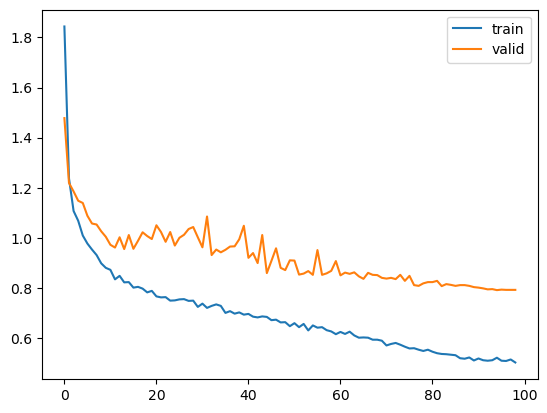

In [22]:
plt.plot(np.arange(0, 99), avg_train_metrics['losses'], label='train')
plt.plot(np.arange(0, 99), avg_valid_metrics['losses'], label='valid')
plt.legend()

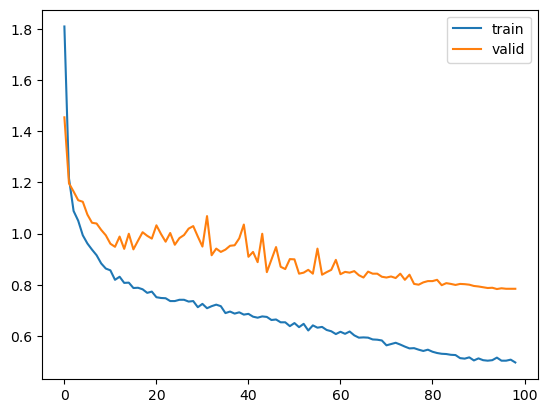

In [23]:
plt.plot(np.arange(0, 99), avg_train_metrics['seg_losses'], label='train')
plt.plot(np.arange(0, 99), avg_valid_metrics['seg_losses'], label='valid')
plt.legend()

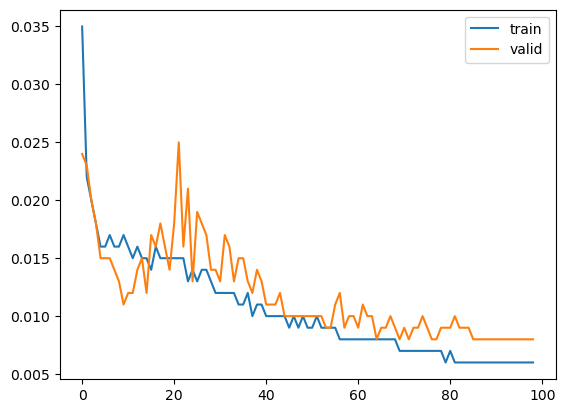

In [24]:
plt.plot(np.arange(0, 99), avg_train_metrics['depth_losses'], label='train')
plt.plot(np.arange(0, 99), avg_valid_metrics['depth_losses'], label='valid')
plt.legend()

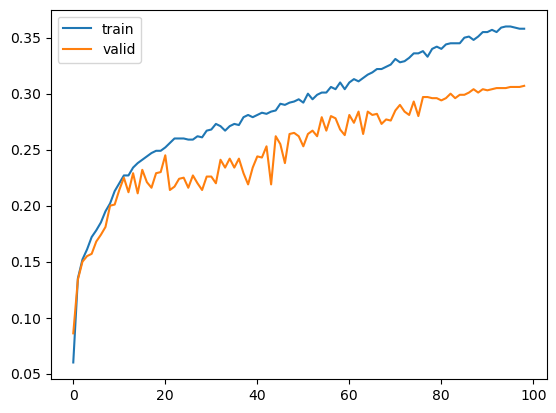

In [25]:
plt.plot(np.arange(0, 99), avg_train_metrics['iou'], label='train')
plt.plot(np.arange(0, 99), avg_valid_metrics['iou'], label='valid')
plt.legend()

In [83]:
sample = test_dataset[100]

In [84]:
left, mask, depth = sample['left'], sample['mask'], sample['depth']
left, mask, depth = left.to(device), mask.to(device), depth.to(device)

In [85]:
model.eval()

with torch.no_grad():
    # get predictions
    pred_seg, pred_depth = model(left.unsqueeze(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


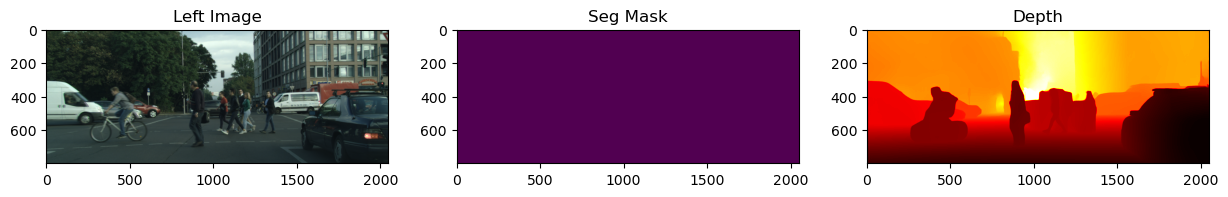

In [87]:
plot_items(left, mask, depth.squeeze(0), labels, NUM_SEG_CLASSES)

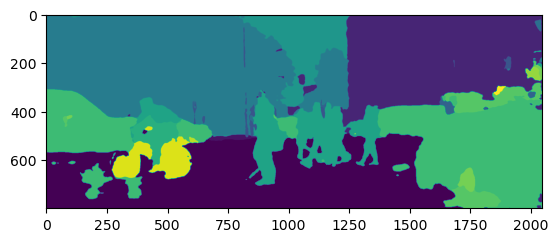

In [90]:
plt.imshow(convert_to_numpy(pred_seg.argmax(dim=1).squeeze(0)))

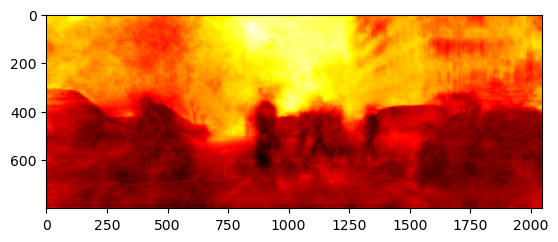

In [95]:
plt.imshow(convert_to_numpy(pred_depth.squeeze(0)), cmap='hot')

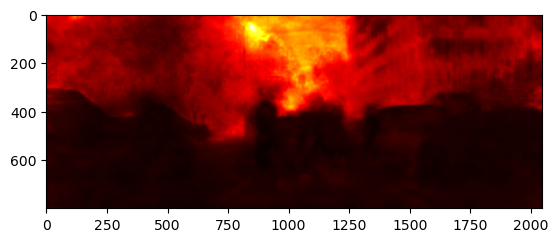

In [96]:
plt.imshow(np.exp(
    convert_to_numpy(pred_depth.squeeze(0))*5), cmap='hot')

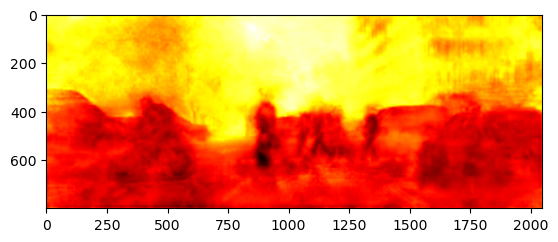

In [97]:
plt.imshow(
    np.log(convert_to_numpy(pred_depth.squeeze(0))*5), cmap='hot')

In [56]:
pred_depth.min(), pred_depth.max(), pred_depth.mean(), pred_depth.std()

(tensor(0.3975, device='cuda:0'),
 tensor(0.9522, device='cuda:0'),
 tensor(0.6971, device='cuda:0'),
 tensor(0.1550, device='cuda:0'))

In [57]:
depth.min(), depth.max(), depth.mean(), depth.std()

(tensor(0.4285, device='cuda:0'),
 tensor(0.8211, device='cuda:0'),
 tensor(0.6628, device='cuda:0'),
 tensor(0.1139, device='cuda:0'))